---
title: "Implementing RAG with Document original structure"
date: "2025-06-26"
categories: [ai,llm,rag,notebook]
draft: true
social-share: true
---

## 1. Background on RAG

Retrival augumented generation is one of the most popular applications of LLM. It involves feeding the LLM with a context that informs it's generation, thus grounding the response in our custom data. Why would we want to do that ? As good as LLM is at language understanding it's knowledge is still frozen in time, in terms of it's knowledge cut off. So, when we need to supply the LLM with some external context we use RAG.

Given a particular query, RAG works around the limited input token window size that an llm has by only supplying relevant context. 

At a high level a typical RAG workflow looks like the following:


![RAG Workflow](../img/rag-workflow.png){#fig-rag-workflow}

In this notebook, we will implement a type of RAG pipline which proves to be a very strong baseline among many known RAG methods as observed in this [research paper](http://arxiv.org/abs/2506.03989). It's called Document original structure RAG or DOS-RAG.The core idea is that post similarity matching the retrieved document chunks are ordered based on their original order in the document rather than sorting by chunk score. 

Let's get started !

## 2. Load the data

We will be using a chapter from a science textbook to demonstrate this technique. Let's see what it looks like ! 

<Figure size 1000x600 with 0 Axes>

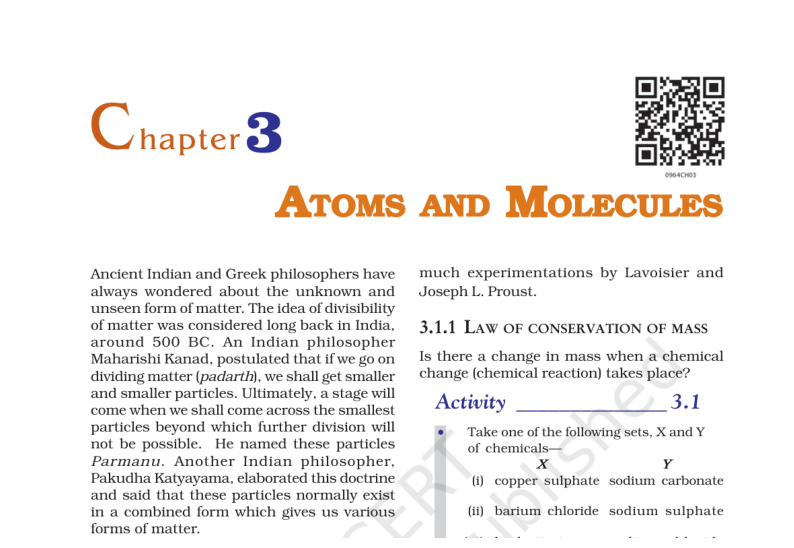

In [6]:
import pymupdf  # PyMuPDF
import matplotlib.pyplot as plt
from PIL import Image
import io

# Read the PDF file
pdf_path = "../assets/dos-rag/atoms and molecules.pdf"  
doc = pymupdf.open(pdf_path)

# Get the first page
first_page = doc[0]

# Convert page to image
mat = first_page.get_pixmap(matrix=pymupdf.Matrix(2, 2))  # 2x zoom for better quality
img_data = mat.tobytes("png")
# Convert to PIL Image for display
img = Image.open(io.BytesIO(img_data))
# Get image dimensions
width, height = img.size

# Crop the top half
top_half = img.crop((0, 0, width, height // 2))

# Display the top half
plt.figure(figsize=(10, 6))
# Display the image
plt.figure(figsize=(10, 12))
plt.imshow(top_half)
plt.axis('off')
plt.show()
# Close the document
doc.close()


Using [llamaindex](https://docs.llamaindex.ai), which is a popular framework for doing all things RAG, let's load the data from the pdf and created the ingestion pipeline from sractch as shown in the [data ingestion guide](https://docs.llamaindex.ai/en/stable/examples/low_level/ingestion/) . For loading pdf, I will be using `pyupdf` which did a decent job of extracting information from with this 2 column layout. While processing the documents in light of DOS-RAG, we have to capture the structure information while creating the [nodes](https://docs.llamaindex.ai/en/stable/module_guides/loading/documents_and_nodes/#documents-nodes) in a llamaindex document. Let's visualise the bounding box information that we get after parsing the document. 

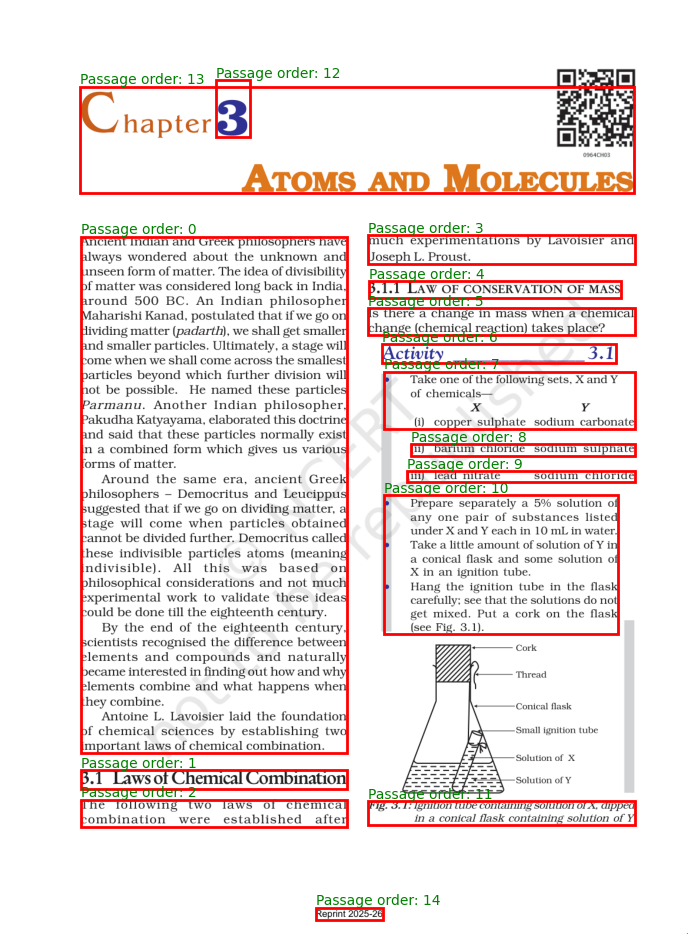

In [7]:
import fitz  # pymupdf
import io
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

doc = fitz.open("../assets/dos-rag/atoms and molecules.pdf")  # open a document
page = doc[0]
text_blocks = page.get_text("blocks")

# Get PDF page size
doc_width, doc_height = page.rect.width, page.rect.height

# Convert page to image (2x zoom for better quality)
mat = fitz.Matrix(2, 2)
pix = page.get_pixmap(matrix=mat)
img_data = pix.tobytes("png")
img = Image.open(io.BytesIO(img_data))
width, height = img.size

# Calculate scale factors
width_scale = width / doc_width
height_scale = height / doc_height

# Collect bounding boxes
bboxes = []
for block in text_blocks:
    if len(block) > 6 and block[6] in (0, 1):  # Text or image block
        x0, y0, x1, y1 = block[:4]
        bboxes.append((x0, y0, x1, y1))

# Plot image and bounding boxes
fig, ax = plt.subplots(figsize=(10, 12))
ax.imshow(img)
for idx, bbox in enumerate(bboxes):
    x0, y0, x1, y1 = bbox
    # Scale bbox coordinates
    rect = patches.Rectangle(
        (x0 * width_scale, y0 * height_scale),
        (x1 - x0) * width_scale,
        (y1 - y0) * height_scale,
        linewidth=2, edgecolor='red', facecolor='none'
    )
    ax.text((x0 * width_scale), ((y0 -2)) * height_scale,f"Passage order: {idx}", color="green")
    ax.add_patch(rect)
ax.axis('off')
plt.show()

doc.close()

This does a decent job of parsing the documents. While this might not lead to the most optimal [chunking](https://stackoverflow.blog/2024/12/27/breaking-up-is-hard-to-do-chunking-in-rag-applications/#h2-d3ac8da19ac50) and providing us with structure information around the document structure:
1. Page number
2. Coordinates of bounding boxes
3. Passage order

We will explore if while chunking we can pass the chunk sequence as metadata as well. This will give us more than enough context around document structure. 

In [8]:
from llama_index.core import SimpleDirectoryReader
from llama_index.core.node_parser import SentenceSplitter

base_splitter = SentenceSplitter(chunk_size=512)
documents = SimpleDirectoryReader(input_files=["../assets/dos-rag/atoms and molecules.pdf"]).load_data()
splitter = SentenceSplitter(
    chunk_size=512,
    chunk_overlap=2
)
nodes = splitter.get_nodes_from_documents(documents)

In [9]:
doc

closed Document('../assets/dos-rag/atoms and molecules.pdf')

In [10]:
from pprint import pprint
doc_pg1 = doc[0]
pprint(doc_pg1.to_haystack_format())

ValueError: document closed